## 5. This notebook explores topic modeling using LDA algorithm. 

A.  Highlights
1. Applied pre-processing steps to text corpus. (We intentionally did not remove stopwords initially)
2. Used gensim library to tokenize unigram corpus.
3. Applied gensim phrases and phraser to train a bigram corpus with minimum count 20. 
4. Used spacy to lemmatize bigram corpus.
5. Built a dictionary of lemmatized words and a corpus of bag of words with no_below 10 and no_above 0.60.  
6. LDA fitted model resulted in -8.80 model perplexity and topic coherence score of 0.33
7. Use pyLDAvis to plot an interactive web-visual. 
8. Used Word Cloud to visualize difficult text and topics.


In [1]:
# Import libraries: 
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS
import spacy
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()

In [2]:
# Get normed text from extracted features: 
df_train = pd.read_csv('../Dataset/extracted_train_features_with_stopwords_pca.csv') 
df_test = pd.read_csv('../Dataset/extracted_test_features_with_stopwords_pca.csv')

In [3]:
df_train.head(2)

,original_text,norm_text,nlp_norm_text,lemma,pos,label,english,pca1,pca2,pca3,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,There is manuscript evidence that Austen conti...,there is manuscript evidence that austen conti...,there is manuscript evidence that austen conti...,"['there', 'be', 'manuscript', 'evidence', 'tha...","['PRON', 'AUX', 'NOUN', 'NOUN', 'SCONJ', 'PROP...",1,1,-1.241217,0.088320,-0.179642,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,in a remarkable comparative analysis mandaean ...,"['in', 'a', 'remarkable', 'comparative', 'anal...","['ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'PROPN', ...",1,1,-0.709833,0.029789,-0.094246,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182


In [4]:
def build_corpus(df, text):
    """convert normalized text in to a list of origina text: corpus"""
    return [x for x in df[text]]


In [5]:
# This is the list of pre-processed sentences:
corpus = build_corpus(df_train,'norm_text')  
corpus[:5]

['there is manuscript evidence that austen continued to work on these pieces as late as the period â and that her niece and nephew anna and james edward austen made further additions as late as',
 'in a remarkable comparative analysis mandaean scholar säve söderberg demonstrated that mani s psalms of thomas were closely related to mandaean texts',
 'before persephone was released to hermes who had been sent to retrieve her hades tricked her into eating pomegranate seeds lrb six or three according to the telling rrb which forced her to return to the underworld for a period each year',
 'cogeneration plants are commonly found in district heating systems of cities hospitals prisons oil refineries paper mills wastewater treatment plants thermal enhanced oil recovery wells and industrial plants with large heating needs',
 'geneva lrb rrb is the second most populous city in switzerland lrb after zürich rrb and is the most populous city of romandie lrb the french speaking part of switzerland 

In [6]:
# Now, convert sentences in the corpus to words: 
custom_stopwords = ['lrb', 'rrb', 'km']
def sentence_to_words(corpus):
    """Pass corpus to convert sentences to words"""
    for sentence in corpus:
        # remove accent marks (This was missed in extracted Features)
        sent = gensim.utils.simple_preprocess(sentence, deacc=True)
        # join sent
        deacc_sent = ",".join(sent)
        # remove custome_stopwords
        yield [token for token in preprocess_string(deacc_sent) if token not in custom_stopwords] 

In [7]:
tokenizer = sentence_to_words(corpus)

# Get the tokenized corpus
corpus_tok = [word for word in tokenizer]

In [8]:
print(corpus_tok[:5])

[['manuscript', 'evid', 'austen', 'continu', 'work', 'piec', 'late', 'period', 'niec', 'nephew', 'anna', 'jame', 'edward', 'austen', 'addit', 'late'], ['remark', 'compar', 'analysi', 'mandaean', 'scholar', 'save', 'soderberg', 'demonstr', 'mani', 'psalm', 'thoma', 'close', 'relat', 'mandaean', 'text'], ['persephon', 'releas', 'herm', 'sent', 'retriev', 'hade', 'trick', 'eat', 'pomegran', 'seed', 'accord', 'tell', 'forc', 'return', 'underworld', 'period', 'year'], ['cogener', 'plant', 'commonli', 'district', 'heat', 'system', 'citi', 'hospit', 'prison', 'oil', 'refineri', 'paper', 'mill', 'wastewat', 'treatment', 'plant', 'thermal', 'enhanc', 'oil', 'recoveri', 'well', 'industri', 'plant', 'larg', 'heat', 'need'], ['geneva', 'second', 'popul', 'citi', 'switzerland', 'zurich', 'popul', 'citi', 'romandi', 'french', 'speak', 'switzerland']]


In [9]:
# Train a bigram model 
from gensim.models.phrases import Phrases, Phraser

def build_bigram(unigram_tokens):
    """Attaches bigrams (set of two adjecent words) for corpus tokens
    that have appeared >=20 times"""

    # Pass unigram tokens to Phrases 
    unigram = Phrases(unigram_tokens, min_count=20)

    # Pass unigram Phrases to Phraser to get bigram: 
    bigram = Phraser(unigram)
    
    return [bigram[word] for word in unigram_tokens]

In [10]:
bigram_corpus = build_bigram(corpus_tok)

In [11]:
print(bigram_corpus[0:3])

[['manuscript', 'evid', 'austen', 'continu', 'work', 'piec', 'late', 'period', 'niec', 'nephew', 'anna', 'jame', 'edward', 'austen', 'addit', 'late'], ['remark', 'compar', 'analysi', 'mandaean', 'scholar', 'save', 'soderberg', 'demonstr', 'mani', 'psalm', 'thoma', 'close_relat', 'mandaean', 'text'], ['persephon', 'releas', 'herm', 'sent', 'retriev', 'hade', 'trick', 'eat', 'pomegran', 'seed', 'accord', 'tell', 'forc', 'return', 'underworld', 'period', 'year']]


In [12]:
# Lemmatize bigram_corpus:
from tqdm import tqdm
tqdm.pandas()

nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner']) 
def get_lemma_or_pos(text, option=None):
    """Pass option as lemma or pos string to obtain lemma or pos from bigram corpus"""
    lemma = []
    pos = []

    for words in tqdm(text): 
        nlp_text = nlp(" ".join(words))
        lemma.append([token.lemma_ for token in nlp_text])
        pos.append([token.pos_ for token in nlp_text])
        
    if option=='lemma':
        return lemma
    if option== 'pos':          
        return pos

In [13]:
# data lemma (run time- 12 minutes)
data_lemma = get_lemma_or_pos(bigram_corpus, option = 'lemma')

# data pos(optional- run time 14 minutes)
#data_pos = get_lemma_or_pos(bigram_corpus, option = 'pos')

100%|██████████| 416239/416239 [11:28<00:00, 604.50it/s]


In [14]:
print(data_lemma[:1])
#print(data_pos[:1])

[['manuscript', 'evid', 'austen', 'continu', 'work', 'piec', 'late', 'period', 'niec', 'nephew', 'anna', 'jame', 'edward', 'austen', 'addit', 'late']]


In [15]:
# We can use data_pos get a count of pos tags and compare it with our previous feature set which contains unigrams

In [16]:
# Create a dictionary: 
id2word = corpora.Dictionary(data_lemma)

# Filter words that appear less than 10 times in the corpus 
# And represent more than 60% of the corpus
id2word.filter_extremes(no_below=10, no_above=0.60)

In [17]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [18]:
# Create Corpus from the dictionary: 
corpus_bow = [id2word.doc2bow(word) for word in data_lemma if word!= 'None']

In [19]:
print(corpus_bow[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [20]:
# Get words from the dictionary: 
print([id2word.get(i) for i in range(20)])

['addit', 'anna', 'austen', 'continu', 'edward', 'evid', 'jame', 'late', 'manuscript', 'nephew', 'niec', 'period', 'piec', 'work', 'analysi', 'close_relat', 'compar', 'demonstr', 'mandaean', 'mani']


### Build Topic Model using LDA: 
#### LdaModel
- **num_topics** : this is the number of topics you need to define beforehand
- **chunksize** : the number of documents to be used in each training chunk
- **alpha** : this is the hyperparameters that affect the sparsity of the topics
- **passess** : total number of training passess

In [21]:
%%time
# LDA model: 
# We chose 1/2 num_topics of best_K obtained from K-means to help interpret clusters i.e 12/2
# This should help generate fewer well-separated topics. 

lda_model = LdaModel(corpus=corpus_bow,
                     num_topics=6,       
                     id2word=id2word,
                     random_state=0,
                     alpha='auto', 
                     chunksize =2000, 
                     passes=20,
                     eta = 'auto',
                     per_word_topics=True)

CPU times: user 14min 32s, sys: 2.65 s, total: 14min 35s
Wall time: 1h 38min 21s


In [22]:
# Print key words in top 6 topics: 
from pprint import pprint
pprint(lda_model.print_topics(6))

[(0,
  '0.051*"franc" + 0.025*"commun" + 0.018*"commun_region" + 0.015*"depart" + '
  '0.012*"north_franc" + 0.012*"pa_calai" + 0.008*"saint" + '
  '0.008*"japanes_footbal" + 0.007*"depart_northwest" + 0.007*"region_pai"'),
 (1,
  '0.033*"plai" + 0.021*"player" + 0.018*"game" + 0.017*"team" + '
  '0.014*"season" + 0.014*"member" + 0.014*"win" + 0.009*"hold" + '
  '0.009*"presid" + 0.009*"big"'),
 (2,
  '0.017*"name" + 0.014*"book" + 0.010*"line" + 0.009*"man" + 0.008*"common" + '
  '0.008*"station" + 0.007*"websit" + 0.007*"japan" + 0.007*"page" + '
  '0.007*"rule"'),
 (3,
  '0.015*"call" + 0.011*"peopl" + 0.010*"includ" + 0.009*"know" + '
  '0.007*"world" + 0.007*"form" + 0.007*"build" + 0.006*"like" + 0.006*"mean" '
  '+ 0.006*"group"'),
 (4,
  '0.025*"citi" + 0.019*"unit_state" + 0.018*"state" + 0.011*"area" + '
  '0.011*"univers" + 0.010*"countri" + 0.010*"town" + 0.010*"nation" + '
  '0.010*"locat" + 0.009*"counti"'),
 (5,
  '0.013*"time" + 0.011*"year" + 0.010*"new" + 0.010*"work

In [23]:
doc_lda = lda_model[corpus_bow]

In [24]:
# View model output
print([doc_lda[word] for word in range(1)])

[([(0, 0.10921464), (1, 0.07638028), (2, 0.16377158), (3, 0.21302287), (4, 0.049805854), (5, 0.38780478)], [(0, [3]), (1, [3]), (2, [2]), (3, [5]), (4, [5]), (5, [1]), (6, [5]), (7, [5]), (8, [0]), (9, [2]), (10, [0]), (11, [5]), (12, [3]), (13, [5])], [(0, [(3, 0.99945)]), (1, [(3, 0.998073)]), (2, [(2, 1.997955)]), (3, [(5, 0.9998668)]), (4, [(5, 0.9996977)]), (5, [(1, 0.99756306)]), (6, [(5, 0.99983394)]), (7, [(5, 1.9995683)]), (8, [(0, 0.99736613)]), (9, [(2, 0.9980038)]), (10, [(0, 0.9931672)]), (11, [(5, 0.9998858)]), (12, [(3, 0.99953777)]), (13, [(5, 0.99996585)])])]


### Evaluate Topic Models: 
1. Model Perplexity: Predicts how well a probability model predicts the sample (Lower score is better)
2. Model Coherence: It measures the degree of semantic similarity between high scoring words in a topic.

In [25]:
%%time
# Model Perplexity: 
print("Perplexity: ", lda_model.log_perplexity(corpus_bow))

Perplexity:  -8.805423292414027
CPU times: user 57.9 s, sys: 249 ms, total: 58.1 s
Wall time: 58.5 s


In [26]:
%%time
# Model Coherence:
coherence_model_lda = CoherenceModel(model = lda_model,
                                     texts = data_lemma,
                                     dictionary = id2word,
                                     coherence= 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.33081342044476486
CPU times: user 2.47 s, sys: 295 ms, total: 2.76 s
Wall time: 5.21 s


### Visualize Topic Model:
1. Use pyLDAvis to help users interpret topics LDA model has fitted to the corpus of text data
2. Use pyLDAvis to extract information from a fitted LDA model in an interactive web-based visualization

In [27]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
%%time
# Visualizatize topics: 
vis = pyLDAvis.gensim.prepare(topic_model=lda_model,
                              corpus=corpus_bow,
                              dictionary=id2word)

vis

CPU times: user 2min 10s, sys: 1.1 s, total: 2min 11s
Wall time: 2min 15s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.245154 -0.156432       1        1  28.174669
5     -0.299907  0.140814       2        1  27.340216
4      0.150549 -0.358986       3        1  16.432241
1      0.073814  0.066542       4        1  10.736151
2      0.197847  0.202262       5        1  10.495906
0      0.122851  0.105799       6        1   6.820813, topic_info=                  Term          Freq         Total Category  logprob  loglift
84               franc  12117.000000  12117.000000  Default  30.0000  30.0000
131               plai  12204.000000  12204.000000  Default  29.0000  29.0000
41                citi  14170.000000  14170.000000  Default  28.0000  28.0000
1383        unit_state  10662.000000  10662.000000  Default  27.0000  27.0000
1208             state  10220.000000  10220.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
26462  region_aquitain   1111.883179   1112.886230   Topic6  -5.3659   2.6843
5229             insid   1101.226318   1102.235962   Topic6  -5.3756   2.6843
27502     picardi_aisn   1002.121277   1003.124634   Topic6  -5.4699   2.6842
1085           protect    989.758606    990.769104   Topic6  -5.4823   2.6842
8370     bass_normandi    978.510986    979.513550   Topic6  -5.4937   2.6842

[213 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
26         5  0.999315       accord
10842      6  0.999472  aisn_depart
1493       2  0.999830        album
113        2  0.999891     american
808        3  0.999791         area
...      ...       ...          ...
705        1  0.999798         word
13         2  0.999938         work
566        1  0.999797        world
149        2  0.999831        write
40         2  0.999896         year

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 5, 2, 3, 1])

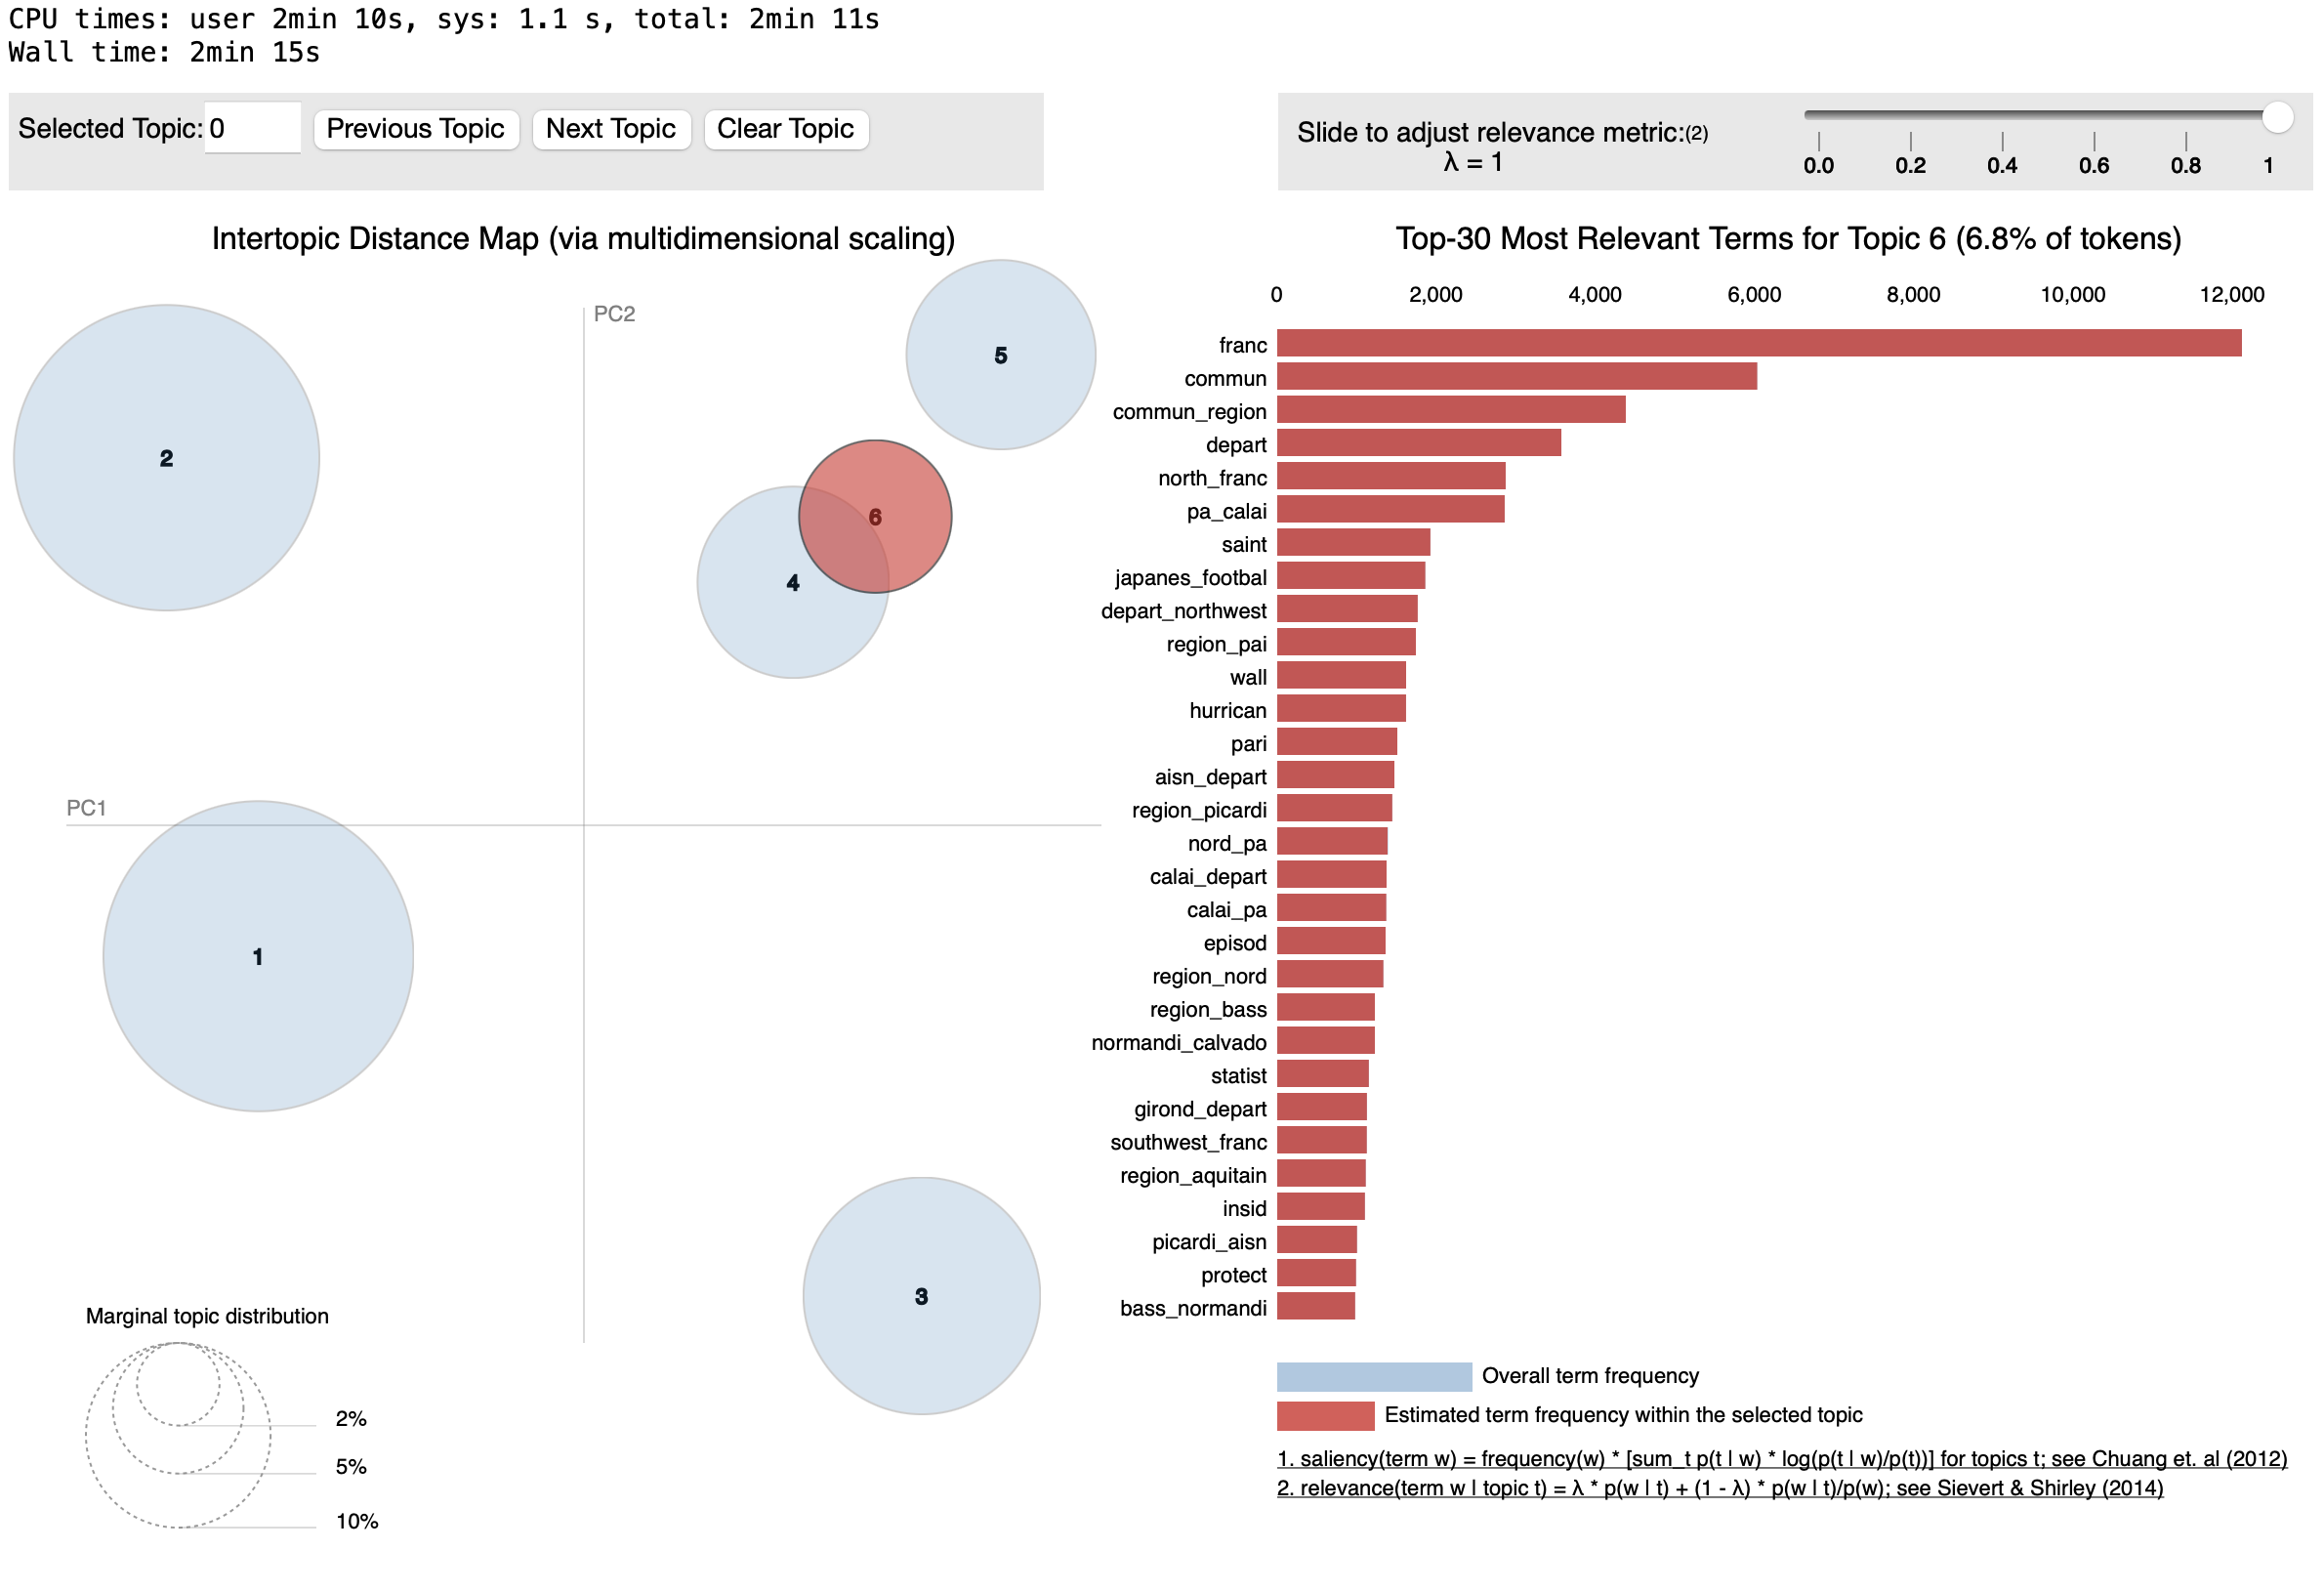

### Observation: 
1. Topics 4 & 6 has a bit of an overlap while topic 1,2 and 5 are well separated as shown in the plot above.   
2. Now, as an additional step we will remove any stopwords, basic English words and explore words using word cloud.

In [29]:
# Extract words from lda_model:
my_dict = {'Topic_' + str(i): [token for token, score in lda_model.show_topic(i, topn=100)] for i in range(0, lda_model.num_topics)}

In [30]:
# Build topic model dataframe: 
topic_model = pd.DataFrame(my_dict, columns = list(my_dict.keys()))

In [31]:
topic_model.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,franc,plai,name,call,citi,time
1,commun,player,book,peopl,unit_state,year
2,commun_region,game,line,includ,state,new
3,depart,team,man,know,area,work
4,north_franc,season,common,world,univers,bear


In [32]:
# Get stopwords and basic english words from additional features we extracted earlier.
from nltk.corpus import stopwords
import numpy as np

# Stopwords:
stopword = list(stopwords.words('english'))

# Additional features:
additional_features = pd.read_csv('../Dataset/additional_features.csv')

In [33]:
def remove_noise_from_topics(df, col):
    
    """This function will return words from the topic which are neither a single stopword nor included in additional features"""
    
    return df[col][(~df[col].isin(stopword+['-PRON-'])) & (~df[col].isin(list(additional_features['Word'])))]

In [34]:
# View topics after removing some of the easy text:
topics = pd.DataFrame([np.unique(remove_noise_from_topics(topic_model,i)) for i in topic_model.columns]).T.fillna(0)
topics.columns = ["topic_"+str(i) for i in range(1, len(topic_model.columns)+1)]                                          
display(topics.iloc[0:20,:])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,abil,advanc,adam,activ,administr,ag
1,air_forc,announc,agre,anim,america,american
2,aisn_depart,armi,airlin,articl,australia,april
3,alfr,athlet,arab,bodi,australian,battl
4,ann,austrian,argentina,caus,bai,british
5,aquitain_girond,born_april,boi,chang,berlin,centuri
6,armenian,born_august,charact,compani,bridg,continu
7,arthur,born_decemb,christian,complet,california,creat
8,babi,born_februari,commonli,cultur,canada,dai
9,bass_normandi,born_june,danc,engin,capit,decemb


In [35]:
# Plot filtered topic in Word Cloud:  
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

def word_cloud(df, col=None):
    
    """This function converts difficult text in each topic and converts it in to a word cloud object"""
    cloud_text = " ".join(map(str, df[col].tolist()))
    return WordCloud(max_font_size=50,
                     max_words=50, 
                     background_color="white",
                     stopwords=STOPWORDS).generate(cloud_text)

topic_1:


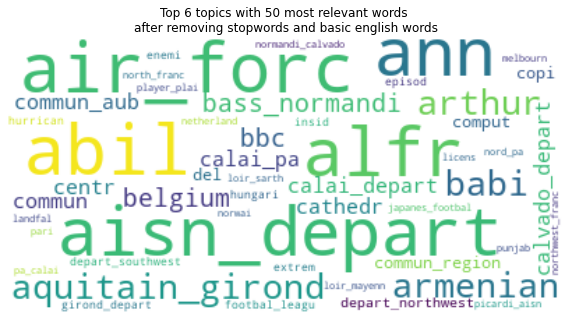

topic_2:


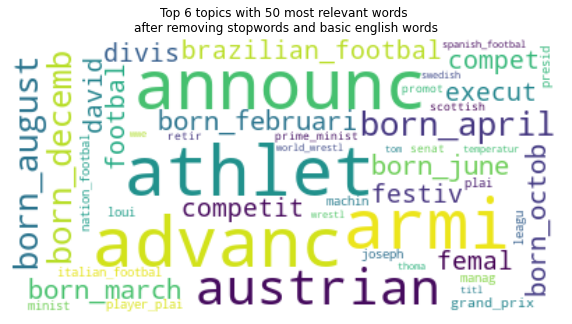

topic_3:


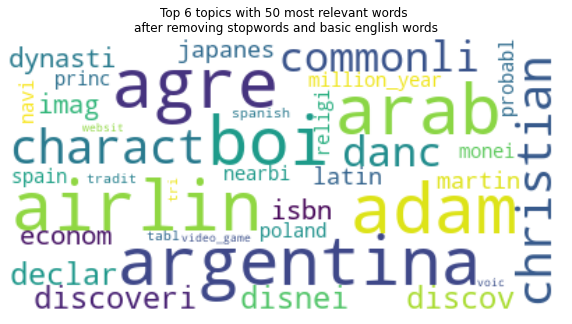

topic_4:


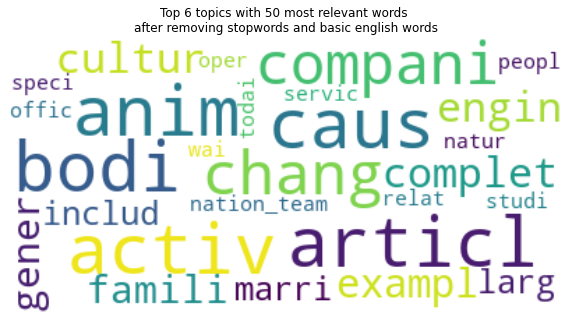

topic_5:


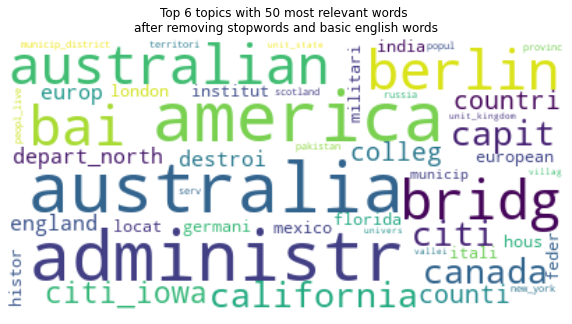

topic_6:


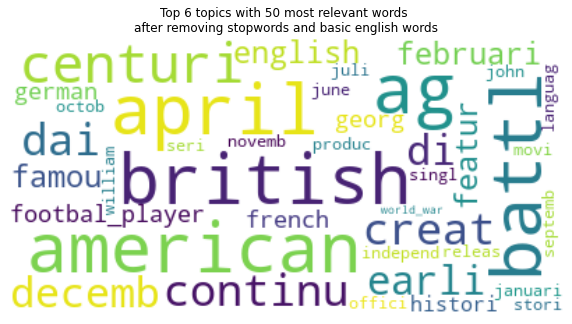

In [37]:
# Plot WordCloud object using matplot lib
for i in topics.columns: 
    _ = plt.figure(figsize = (10,10))
    _ =print(i+':'),plt.imshow(word_cloud(topics, i), interpolation="bilinear")
    _ =plt.axis("off")
    _ = plt.title('Top 6 topics with 50 most relevant words \nafter removing stopwords and basic english words')
    _ = plt.show()

###### Observation: 
1. Through wordcloud visual, after filtering out some noise from the topics, we can see topics text importance more clearly in our corpus. 
2. Obtained lower topic model perplexity score of -8.8 and coherence score of 0.33 after some preprocessing and lemmitization. This, to some extent preserved topic context and showed us relevant words contained under each topic. Example: topic 1 which represents 28.2% tokens appears to relate to 'air travel'. Moreover, in the word cloud we can also see some longer words which may be contributing to text difficulty as observed from supervised learning model where sentence length and average word length accounted for >7% in predicting text difficulty.
4. By reducing number of topics from 12 to 6, average coherence score reduced slightly while also reducing overlapping topics, which was an interesting observation. 
5. In future, we intend to build a vocabulary out of word cloud text to further evaluate text difficulty by above topics. It's possible that some topics contain more difficult text than others. 